In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import requests
from array import array
import concurrent.futures


class Chispazo:
    def __init__(self) -> None:
        self.ranges_per_position = ((1, 24), (2, 25), (3, 26), (4, 27), (5, 28))
        self.data = pd.read_csv("games_csv/Chispazo.csv")
        self.frequencies_per_position = [
            self.data[f"R{i}"].value_counts().sort_index() for i in range(1, 6)
        ]
        self.most_frequent_numbers = []
        self.less_frequent_numbers = []
        for i in range(5):
            s = self.frequencies_per_position[i]
            q = s.quantile(0.5)
            self.most_frequent_numbers.append(list(s[s >= q].index))
            self.less_frequent_numbers.append(list(s[s < q].index))

        self.num_frequencies = self.data.iloc[:, 1:6].stack().value_counts()
        # self.number_of_frequencies_per_position={1:10,2:12,3:16,4:12,5:10}
        self.number_of_frequencies_per_position = {1: 9, 2: 9, 3: 9, 4: 9, 5: 9}
        self.top_frequencies_per_position = [
            self.data[f"R{i}"]
            .value_counts()
            .nlargest(self.number_of_frequencies_per_position[i])
            for i in range(1, 6)
        ]
        self.top_nums = [
            list(freq_pos.index) for freq_pos in self.top_frequencies_per_position
        ]
        self.num_positions = 5

        self.most_frequent_total_combinations = 1
        self.less_frequent_total_combinations = 1
        for i in range(5):
            most_freq_count = len(self.most_frequent_numbers[i])
            less_freq_count = len(self.less_frequent_numbers[i])
            self.most_frequent_total_combinations *= most_freq_count
            self.less_frequent_total_combinations *= less_freq_count

    # def download_csv(game_name: str = "Chispazo"):
    #     """
    #     download csv file from the records page
    #     """
    #     url = f"https://www.pronosticos.gob.mx/Documentos/Historicos/{game_name}.csv"
    #     response = requests.get(url, verify=False)
    #     with open(f"games_csv/{game_name}.csv", "wb") as file:
    #         file.write(response.content)

    def generate_random_combination(self) -> list:
        """
        generate random combination of numbers beetween 1,28 using the rango of posiitons for each value

        """
        combination = array("b")
        latest_sum = 0
        for rango in self.ranges_per_position:
            random_value = np.random.randint(latest_sum + 1, rango[1] + 1)
            combination.append(random_value)
            latest_sum = random_value
        return combination

    def generate_combination_top_frequencies(self) -> list:
        """
        generan una cierta cantidad de combinaciones junto con sus respectivas probabilidades, ordenadas de mayor a menor.
        """
        nums = []
        for i in range(self.num_positions):
            top_nums_i = self.top_nums[i]
            nums += top_nums_i
        nums = list(set(nums))  # eliminar elementos repetidos
        values = []
        for i in range(self.num_positions):
            num = random.choice(self.top_nums[i])
            values.append(num)
        return values

    def calculate_probability_v1(self, combinacion: list):
        """
        La primera función utiliza la frecuencia de cada número en cada posición de la combinación
        y el número total de frecuencias de cada número para calcular la
        probabilidad de que la combinación sea ganadora.
        """
        probabilidad = 1
        for i, num in enumerate(combinacion):
            probabilidad *= (
                self.frequencies_per_position[i].get(num, 0) / self.num_frequencies[num]
            )
        return probabilidad

    def calculate_probability_v2(self, row: pd.core.series.Series):
        """
        La segunda función utiliza dos listas de números, los más frecuentes y los menos frecuentes,
        y asigna un peso menor a los números menos frecuentes. Luego, cuenta la cantidad de números en
        la combinación que se encuentran en la lista de números más frecuentes y los que se encuentran en la lista de números menos
        frecuentes con un peso menor y divide la cantidad total por 5 para obtener la probabilidad de que la combinación sea ganadora.
        """
        # total_combinaciones = 10068347520 # número total de combinaciones posibles
        count = 0
        for r in range(1, 6):
            if row[f"R{r}"] in self.most_frequent_numbers[r - 1]:
                count += 1
            elif row[f"R{r}"] in self.less_frequent_numbers[r - 1]:
                count += 0.5  # agregamos un peso menor para los números poco frecuentes
        probabilidad = count / 5
        return probabilidad

    def calculate_probability_v3(self, row: pd.core.series.Series):
        """
        La tercera función utiliza dos listas de números, los más frecuentes y los menos frecuentes,
        y asigna un peso proporcional a la posición de los números en las listas.
        Luego, cuenta la cantidad de números en la combinación que se encuentran en la lista de números más frecuentes
        y los que se encuentran en la lista de números menos frecuentes con un peso proporcional y divide la cantidad total por 5
        para obtener la probabilidad de que la combinación sea ganadora.
        """

        count = 0
        for r in range(1, 6):
            number = row[f"R{r}"]
            try:
                position = self.frequencies_per_position[r - 1].index.get_loc(number)
            except KeyError as e:
                return 0.0001
            frequency = self.frequencies_per_position[r - 1][number]
            weight = (
                1
                + (self.frequencies_per_position[r - 1].size - position)
                / self.frequencies_per_position[r - 1].size
            )
            if number in self.most_frequent_numbers[r - 1]:
                count += weight * frequency / self.most_frequent_total_combinations
            elif number in self.less_frequent_numbers[r - 1]:
                count += (
                    0.5 * weight * frequency / self.less_frequent_total_combinations
                )
        probabilidad = count / 5
        return probabilidad

    def calculate_standard_deviation(self, combination):
        """
        Calcula la desviación estándar de una combinación de números utilizando los resultados históricos de Chispazo.
        """
        df_comb = self.data[
            (self.data["R1"].isin(combination))
            & (self.data["R2"].isin(combination))
            & (self.data["R3"].isin(combination))
            & (self.data["R4"].isin(combination))
            & (self.data["R5"].isin(combination))
        ]
        if len(df_comb) == 0:
            # La combinación no ha sido ganadora en el pasado
            return np.nan
        else:
            return df_comb["Premio"].std()

    def generate_combinations(self, n=9):
        """
        genera n numero de combinaciones con su respectiva probabilidad cada una, ordenada de mayor a menor
        """
        # combinaciones = [self.generate_random_combination() for i in range(n)]
        # probabilidades = [self.calculate_probability_v1(c) for c in combinaciones]
        # combinaciones_probables = sorted(
        #     list(zip(combinaciones, probabilidades)), key=lambda x: x[1], reverse=True
        # )
        # return combinaciones_probables
    
        combinaciones_probables = []
    
        with concurrent.futures.ThreadPoolExecutor() as executor:
            futures = [executor.submit(self.generate_random_combination) for _ in range(n)]
            
            for future in concurrent.futures.as_completed(futures):
                combinacion = future.result()
                probabilidad = self.calculate_probability_v1(combinacion)
                combinaciones_probables.append((combinacion, probabilidad))
        
        combinaciones_probables = sorted(combinaciones_probables, key=lambda x: x[1], reverse=True)
        return combinaciones_probables
    

    def generate_combinations_top_frequencies(self, n=9):
        """
        genera n numero de combinaciones con su respectiva probabilidad cada una,
        ordenada de mayor a menor usando solos los numeros mas frecuentes de cada posición
        """
        combinaciones = [self.generate_combination_top_frequencies() for i in range(n)]
        probabilidades = [self.calculate_probability_v1(c) for c in combinaciones]
        combinaciones_probables = sorted(
            list(zip(combinaciones, probabilidades)), key=lambda x: x[1], reverse=True
        )
        return combinaciones_probables

    def generar_probabilidad_de_resultados_historicos(
        self,
        file_name: str = "games_csv/ChispazoProbabilidad.csv",
    ):
        """
        agragar una columna de probabilidad a la data historica con sus respectivos porcentajes de probabilidad
        """
        self.data["Probabilidad"] = self.data[["R1", "R2", "R3", "R4", "R5"]].apply(
            lambda row: round(self.calculate_probability_v3(row), 4), axis=1
        )
        # self.data.to_csv(file_name, index=False, mode='a', header=not os.path.exists(file_name))
        self.data.to_csv(file_name, index=False, header=not os.path.exists(file_name))

    def guardar_combinaciones_probables(
        self, file_name: str, threshold: int, iterations: int = 100000
    ):
        combinaciones_probables = self.generar_combinaciones_probables(iterations)
        df_combinaciones_probables = pd.DataFrame(
            columns=[f"R{i}" for i in range(1, 6)]
        )
        probabilidad_column = []
        for combinacion, probabilidad in combinaciones_probables:
            if probabilidad > threshold:
                df_combinaciones_probables = df_combinaciones_probables.append(
                    pd.Series(combinacion, index=df_combinaciones_probables.columns),
                    ignore_index=True,
                )
                probabilidad_column.append(probabilidad)

        df_combinaciones_probables.insert(
            loc=len(df_combinaciones_probables.columns),
            column="probabilidad",
            value=probabilidad_column,
        )
        try:
            df_existing = pd.read_csv(file_name)
            df_existing = df_existing.append(
                df_combinaciones_probables, ignore_index=True
            )
            df_existing.to_csv(
                file_name, index=False, mode="a", header=not os.path.isfile(file_name)
            )
        except FileNotFoundError:
            df_combinaciones_probables.to_csv(file_name, index=False)


ch = Chispazo()
print(ch.data.head(-5))

      CONCURSO  R1  R2  R3  R4  R5       FECHA
0         9668   5  10  13  15  20  02/03/2023
1         9667   6   7  19  23  24  02/03/2023
2         9666   7  19  20  25  28  01/03/2023
3         9665   1   6  16  18  23  01/03/2023
4         9664  11  12  13  17  26  28/02/2023
...        ...  ..  ..  ..  ..  ..         ...
9658        10   1   3   8  11  17  05/02/1999
9659         9   4  17  18  21  22  02/02/1999
9660         8   4   8   9  20  22  29/01/1999
9661         7   2   8  11  15  22  26/01/1999
9662         6   1   9  10  16  17  22/01/1999

[9663 rows x 7 columns]


In [110]:
result_today=[2,18,21,25,27]
print(ch.calculate_probability_v1(result_today))
# print(ch.calculate_probability_v2(result_today))
# print(ch.calculate_probability_v3(result_today))


0.004265617117189303


In [98]:
ch.generar_probabilidad_de_resultados_historicos()

In [ ]:
combinaciones_probables = ch.generate_combinations(90)
for i, c in enumerate(combinaciones_probables):
    print(f'{i+1}. {c[0]} - probabilidad: {c[1]*100:.2f}%')


1. array('b', [1, 6, 15, 23, 28]) - probabilidad: 7.20%
2. array('b', [1, 8, 14, 22, 27]) - probabilidad: 6.99%
3. array('b', [1, 6, 15, 18, 28]) - probabilidad: 6.77%
4. array('b', [1, 7, 13, 16, 28]) - probabilidad: 6.33%
5. array('b', [1, 11, 12, 23, 28]) - probabilidad: 6.28%
6. array('b', [2, 6, 16, 19, 28]) - probabilidad: 6.23%
7. array('b', [1, 10, 18, 20, 28]) - probabilidad: 6.09%
8. array('b', [2, 8, 15, 20, 27]) - probabilidad: 5.77%
9. array('b', [1, 5, 16, 23, 27]) - probabilidad: 5.56%
10. array('b', [2, 10, 14, 18, 28]) - probabilidad: 5.55%
11. array('b', [2, 8, 19, 22, 28]) - probabilidad: 5.39%
12. array('b', [1, 7, 10, 22, 27]) - probabilidad: 5.37%
13. array('b', [1, 7, 19, 23, 27]) - probabilidad: 5.32%
14. array('b', [1, 7, 10, 19, 27]) - probabilidad: 5.20%
15. array('b', [1, 9, 14, 23, 25]) - probabilidad: 5.15%
16. array('b', [1, 7, 13, 24, 26]) - probabilidad: 5.13%
17. array('b', [2, 4, 15, 20, 28]) - probabilidad: 5.01%
18. array('b', [3, 8, 16, 17, 28]) - 

In [6]:
combinaciones_probables_top_10 = ch.generate_combinations_top_frequencies(9)
for i, c in enumerate(combinaciones_probables_top_10):
    print(f'{i+1}. {c[0]} - probabilidad: {c[1]*100:.2f}%')

1. [2, 7, 17, 24, 28] - probabilidad: 5.06%
2. [2, 7, 17, 19, 26] - probabilidad: 4.10%
3. [5, 6, 11, 19, 27] - probabilidad: 2.94%
4. [3, 12, 17, 24, 27] - probabilidad: 2.77%
5. [3, 6, 18, 16, 26] - probabilidad: 2.43%
6. [7, 5, 15, 24, 26] - probabilidad: 1.28%
7. [8, 5, 16, 19, 26] - probabilidad: 1.18%
8. [6, 4, 10, 20, 22] - probabilidad: 0.73%
9. [8, 7, 16, 24, 22] - probabilidad: 0.66%


In [ ]:
ch.guardar_combinaciones_probables("resultados/probables.csv",0.08,iterations=1000000)

In [11]:
def generar_combinacion_probabilidad(dummy_arg):
    combinacion = ch.generate_random_combination()
    probabilidad = ch.calculate_probability_v3(pd.Series(combinacion,index=['R1','R2','R3','R4','R5']))
    return (*combinacion, probabilidad)

In [12]:
import random
import sqlite3
from multiprocess import Pool

# Conexión a la base de datos
conn = sqlite3.connect('chispazoon.db')
c = conn.cursor()

# Creación de la tabla para almacenar los resultados
c.execute('''CREATE TABLE IF NOT EXISTS resultados
             (id INTEGER PRIMARY KEY AUTOINCREMENT, r1 INTEGER, r2 INTEGER, r3 INTEGER, r4 INTEGER, r5 INTEGER, probabilidad REAL)''')
conn.commit()

# Función para generar combinaciones y calcular probabilidad en paralelo
n = 10000
resultados = []
pool = Pool()  # Inicialización del pool de procesos
resultados = pool.map(generar_combinacion_probabilidad, range(n))  # Ejecución en paralelo de la función
pool.close()  # Cierre del pool de procesos
pool.join()  # Espera a que todos los procesos finalicen

# Almacenamiento de resultados en la base de datos
c.executemany('INSERT INTO resultados (R1, R2, R3, R4, R5, probabilidad) VALUES (?, ?, ?, ?, ?, ?)', resultados)
conn.commit()

# Selección de los resultados con la mayor probabilidad
c.execute('SELECT * FROM resultados ORDER BY probabilidad DESC LIMIT 10')
top_resultados = c.fetchall()
print(top_resultados)

# Cierre de la conexión a la base de datos
conn.close()


[(7244503, 1, 7, 13, 20, 28, 0.007562025435006263), (7494503, 1, 7, 13, 20, 28, 0.007562025435006263), (7744503, 1, 7, 13, 20, 28, 0.007562025435006263), (7994503, 1, 7, 13, 20, 28, 0.007562025435006263), (8244503, 1, 7, 13, 20, 28, 0.007562025435006263), (8494503, 1, 7, 13, 20, 28, 0.007562025435006263), (8744503, 1, 7, 13, 20, 28, 0.007562025435006263), (8994503, 1, 7, 13, 20, 28, 0.007562025435006263), (9244503, 1, 7, 13, 20, 28, 0.007562025435006263), (9494503, 1, 7, 13, 20, 28, 0.007562025435006263)]


## FREQUENCIA DE LOS NUMEROS EN COMBINACIONES GANADORAS


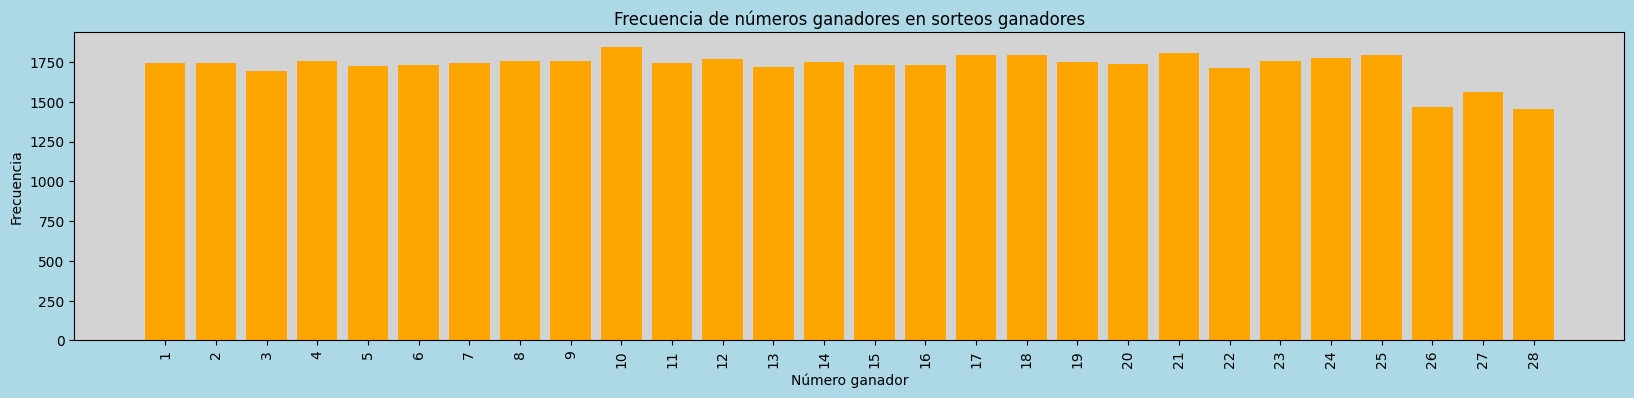

In [6]:
# num_frequencies = ch.data.iloc[:, 1:6].stack().value_counts()
import matplotlib

# matplotlib.rcParams.update({'font.size': 14})
matplotlib.rcParams['axes.facecolor'] = 'lightgray'


fig, ax = plt.subplots(figsize=(20, 4))
ax.bar(ch.num_frequencies.index, ch.num_frequencies.values, color='orange')
ax.set_xlabel('Número ganador')
ax.set_ylabel('Frecuencia')
plt.xticks(range(1,29),rotation=90)
ax.set_title('Frecuencia de números ganadores en sorteos ganadores')
fig.set_facecolor('lightblue')

plt.show()

## desviación estándar de la combinación de números más frecuentes según su posición

In [145]:
from itertools import product
from math import sqrt
combinations = list(product(ch.freq_pos[0].sort_values(ascending=False).head(2).index.tolist(), 
                             ch.freq_pos[1].sort_values(ascending=False).head(2).index.tolist(),
                             ch.freq_pos[2].sort_values(ascending=False).head(2).index.tolist(), 
                             ch.freq_pos[3].sort_values(ascending=False).head(2).index.tolist(), 
                             ch.freq_pos[4].sort_values(ascending=False).head(2).index.tolist(), ))

top_nums = []
for i in range(1, 6):
    # Ordenar los valores de freq_pos[i-1] de mayor a menor frecuencia
    sorted_values = ch.freq_pos[i-1].sort_values(ascending=False)
    # Obtener los 10 valores más frecuentes y convertirlos a una lista
    top = sorted_values.head(10).index.tolist()
    top_nums.append(top)

# print(len(combinations),combinations[:90])
print(ch.data.head())
# frecuencias = ch.data['combinacion'].apply(lambda x: sum(combinations.apply(lambda y: y == x)))
frequencies = []
for combination in combinations:
    freq = ch.data.apply(lambda x: all(elem in x[1:6] for elem in combination), axis=1).sum()
    frequencies.append(freq)

# # Calcular la media y la desviación estándar de las frecuencias
mean = sum(frequencies) / len(frequencies)
std_dev = sqrt(sum([(x - mean)**2 for x in frequencies]) / len(frequencies))


   CONCURSO  R1  R2  R3  R4  R5       FECHA
0      9668   5  10  13  15  20  02/03/2023
1      9667   6   7  19  23  24  02/03/2023
2      9666   7  19  20  25  28  01/03/2023
3      9665   1   6  16  18  23  01/03/2023
4      9664  11  12  13  17  26  28/02/2023


In [147]:
std_dev

0.0

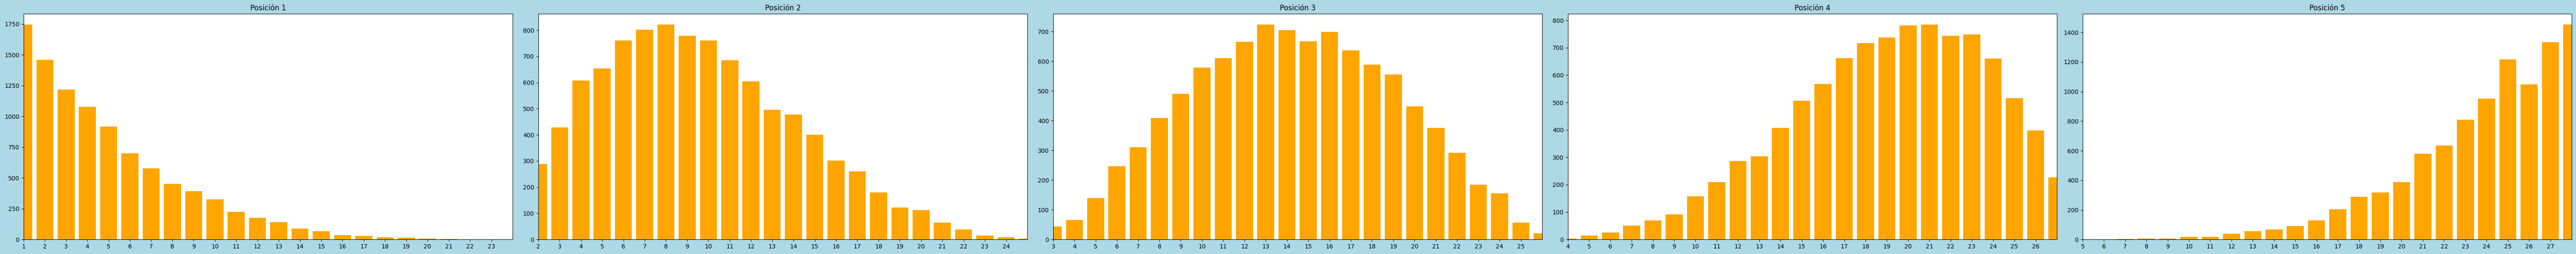

In [21]:
# Crear una tabla de frecuencias para cada posición

# Crear la figura y los subplots
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(60, 6))
fig.set_facecolor('lightblue')

# Crear cada tabla de frecuencias como un gráfico de barras y ajustar los límites del eje x
for i in range(5):
    axs[i].bar(ch.frequencies_per_position[i].index, ch.frequencies_per_position[i].values,color="orange")
    axs[i].set_title(f'Posición {i+1}')
    axs[i].set_xlim(ch.ranges_per_position[i])
    axs[i].set_xticks(range(*ch.ranges_per_position[i]))
    axs[i].set_xticklabels(range(*ch.ranges_per_position[i]))
# Ajustar la posición de los subplots y mostrar la figura
plt.tight_layout()
plt.show()

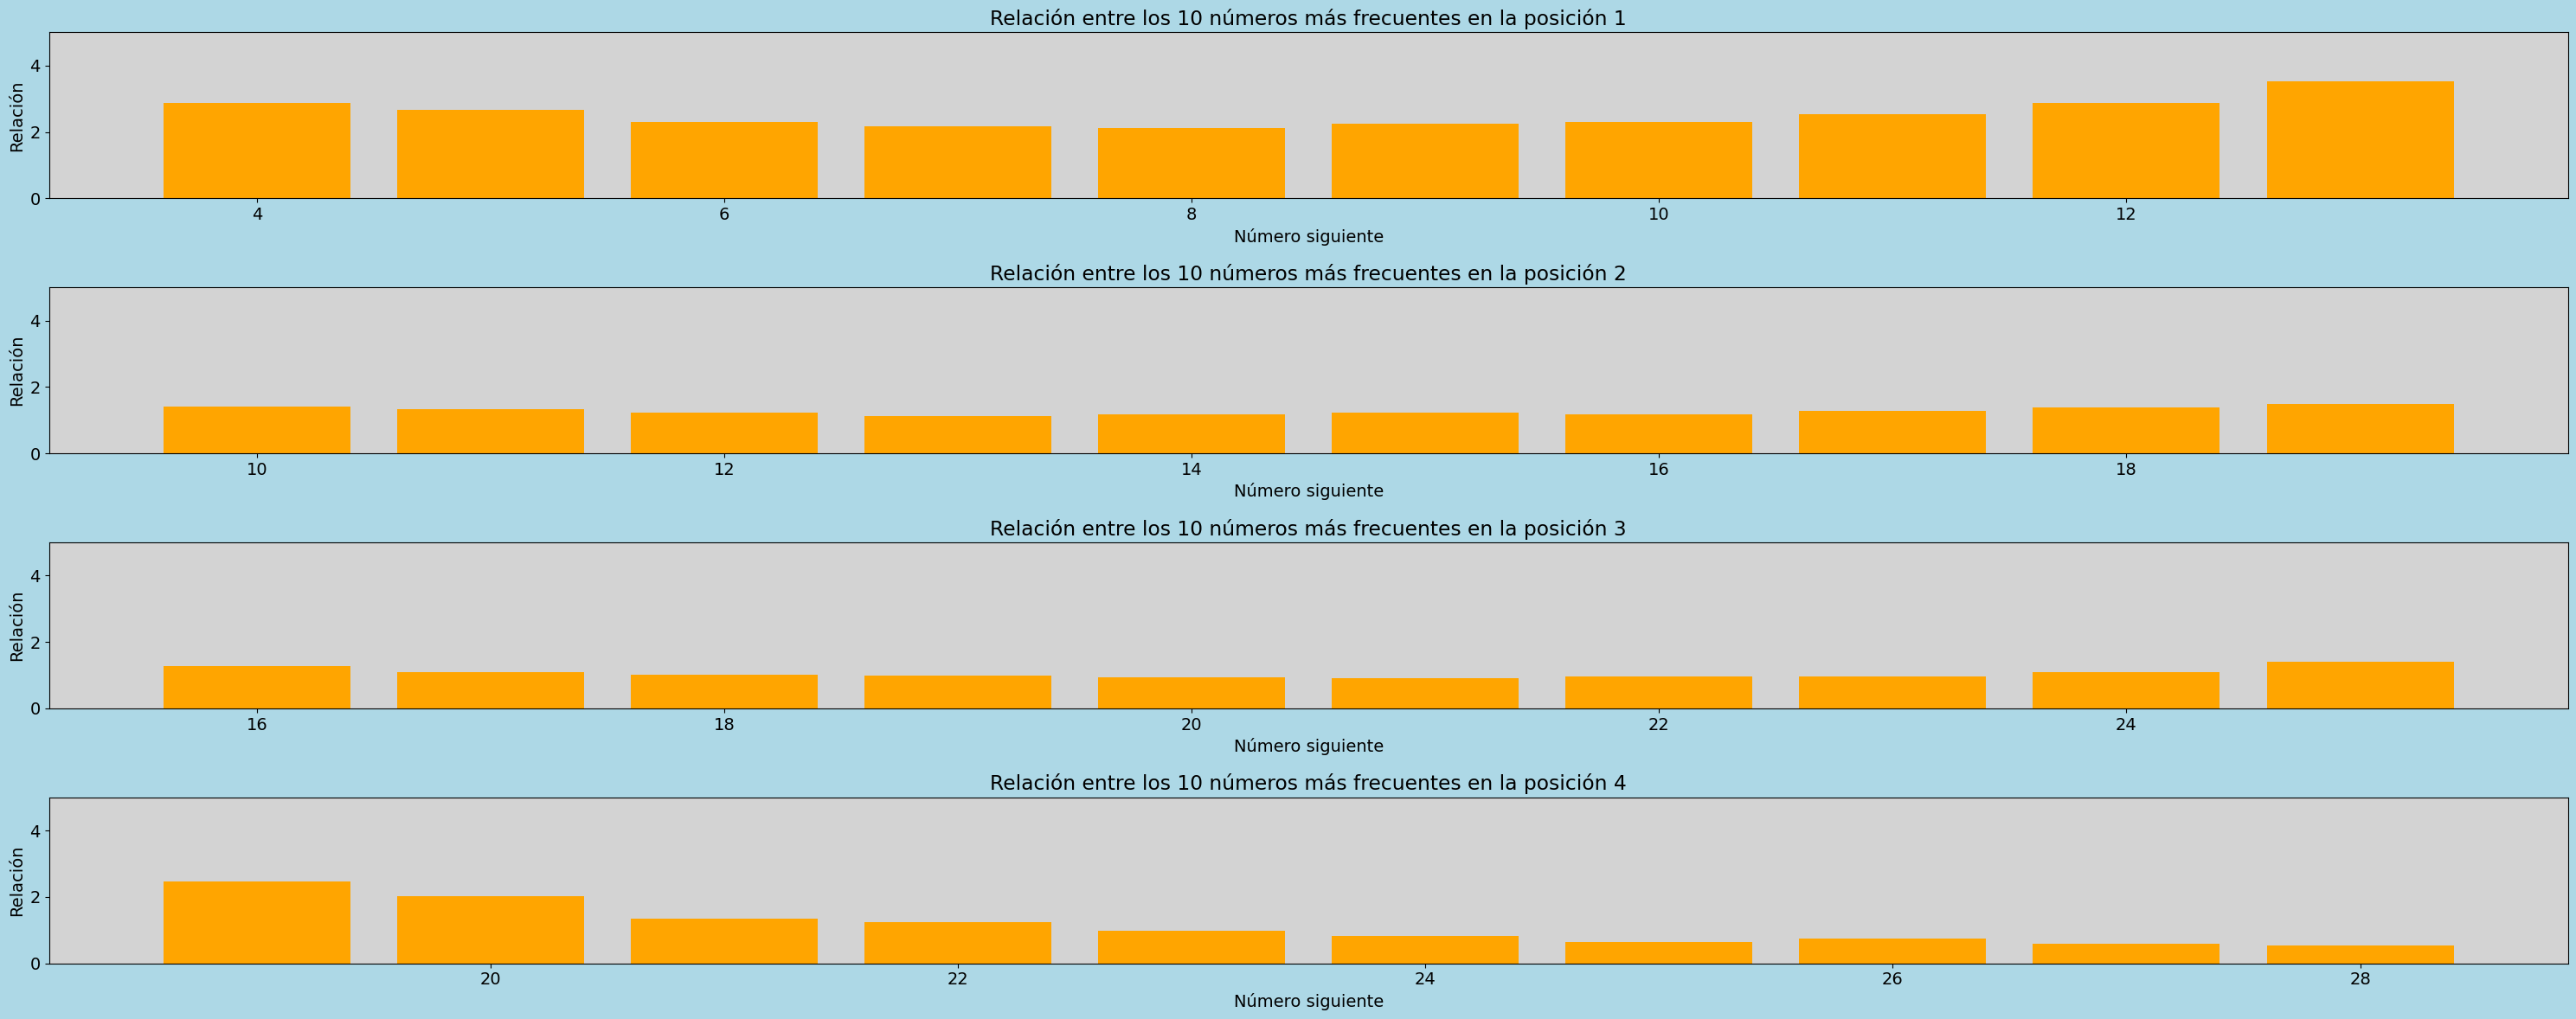

In [95]:
relaciones = pd.DataFrame(columns=['posicion', 'num_actual', 'num_siguiente', 'relacion'])

# Calcular las relaciones entre los números más frecuentes en cada posición
for i in range(1, 5):
    # Obtener la lista de los 10 números más frecuentes en la posición actual
    top_actual = freq_pos[i-1].sort_values(ascending=False).head(10)
    
    # Obtener la lista de los 10 números más frecuentes en la posición siguiente
    top_siguiente = freq_pos[i].sort_values(ascending=False).head(10)
    
    # Calcular la relación entre cada par de números más frecuentes
    for num_actual, freq_actual in top_actual.items():
        for num_siguiente, freq_siguiente in top_siguiente.items():
            relacion = freq_actual / freq_siguiente
            nueva_relacion ={'posicion': i, 'num_actual': num_actual, 'num_siguiente': num_siguiente, 'relacion': relacion}
            relaciones = pd.concat([relaciones, pd.DataFrame.from_records([{'posicion': i, 'num_actual': num_actual, 'num_siguiente': num_siguiente, 'relacion': relacion}])])


grupos = relaciones.groupby('posicion')

# Crear una figura con subplots para cada posición
fig, axs = plt.subplots(len(grupos), figsize=(30, 3 * len(grupos)))
fig.set_facecolor('lightblue')


# Iterar sobre cada grupo y crear una gráfica para cada uno
for i, (posicion, datos) in enumerate(grupos):
    axs[i].bar(datos['num_siguiente'], datos['relacion'], color='orange')
    axs[i].set_xlabel('Número siguiente')
    axs[i].set_ylabel('Relación')
    axs[i].set_title(f'Relación entre los 10 números más frecuentes en la posición {posicion}')
    axs[i].set_ylim(0, 5) # Ajustar el límite vertical para ver mejor las relaciones
    
plt.tight_layout()
plt.show()